In [1]:
import gc
import glob
import os
import sys
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from random import randrange
from tqdm import tqdm, tnrange
from tqdm.notebook import tqdm_notebook

import warnings

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from keras.optimizer_v2.gradient_descent import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, MaxPooling2D, Flatten, Conv2D, Lambda, Dropout, LeakyReLU, BatchNormalization, Activation, AveragePooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

from mlxtend.evaluate import accuracy

from tensorflow.keras.optimizers import Adam,RMSprop,SGD, Nadam
#from tensorflow.keras.utils import to_categorical
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.applications import VGG16

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # ignore tensorflow warnings
warnings.filterwarnings("ignore")

In [3]:
path_data = "data/data_palm_vein/NIR"

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_data,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=1007,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)


Found 6000 files belonging to 500 classes.
Using 4800 files for training.
Metal device set to: Apple M1


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_data,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=1007,
    validation_split=0.15,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 6000 files belonging to 500 classes.
Using 900 files for validation.


In [6]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_data,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=1007,
    validation_split=0.15,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 6000 files belonging to 500 classes.
Using 900 files for validation.


In [7]:
from keras.applications.resnet_v2 import ResNet50V2

def resnet_model_tf(input_shape=(128, 128, 3), nombre_classes=500):
    resnet = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
    resnet.tbatch_sizenable = False
    model = Sequential()
    model.add(resnet)
    model.add(Flatten())
    model.add(Dense(4096, activation='LeakyReLU'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='LeakyReLU'))
    model.add(Dropout(0.5))
    model.add(Dense(nombre_classes, activation='softmax'))
    
    print(model.summary())
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.7, 
                                            min_lr=0.00000000001)
    return model, learning_rate_reduction

In [8]:
model, learning_rate_reduction = resnet_model_tf()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 4, 4, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              134221824 
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               2

In [9]:
epochs = 20
batch = 32

print("\n ================= Training : RESNET model ================= \n")
print("             Epochs :  {}   |   Batch size : {} ".format(epochs, batch))
print("\n =========================================================== \n")
trained = model.fit(train_ds, validation_data = val_ds, epochs=epochs, batch_size=batch, callbacks=[learning_rate_reduction])


 ================= Training : RESNET model ================= 

             Epochs :  20   |   Batch size : 32 


Epoch 1/20
150/150 [==============================] - 158s 1s/step - loss: 6.0183 - accuracy: 0.0383 - val_loss: 15.3977 - val_accuracy: 0.0089
Epoch 2/20
150/150 [==============================] - 154s 1s/step - loss: 2.4914 - accuracy: 0.4800 - val_loss: 8.0070 - val_accuracy: 0.0089
Epoch 3/20
150/150 [==============================] - 150s 1s/step - loss: 0.8266 - accuracy: 0.8121 - val_loss: 20.9041 - val_accuracy: 0.0100
Epoch 4/20
150/150 [==============================] - 149s 994ms/step - loss: 0.8487 - accuracy: 0.8217 - val_loss: 31.4519 - val_accuracy: 0.0267
Epoch 5/20
150/150 [==============================] - 149s 995ms/step - loss: 0.8725 - accuracy: 0.8500 - val_loss: 13.8331 - val_accuracy: 0.0733
Epoch 6/20
150/150 [==============================] - 729s 5s/step - loss: 0.5899 - accuracy: 0.9106 - val_loss: 225.7937 - val_accuracy: 0.0011
Epoch 7/20
150/

In [10]:
val = model.evaluate(test_ds)
input_shape = (128, 128, 3)

print("\n ================= Evaluation : Resnet model ================= \n")
print("  With : \n")
print("Batch size         :  {}     |   Epochs      : {} ".format(batch, epochs))
print("Nombres de classes :  {}    |   Input shape : {} \n".format(len(train_ds.class_names), input_shape))
print("\n ============================================================= \n")

print("  Results : \n")
print("Loss  : %.2f%%" % (val[0] * 100))
print("Score : %.2f%%" % (val[1] * 100))

29/29 [==============================] - 3s 119ms/step - loss: 0.0095 - accuracy: 0.9978

 ================= Evaluation : Resnet model ================= 

  With : 

Batch size         :  32     |   Epochs      : 20 
Nombres de classes :  500    |   Input shape : (128, 128, 3) 



  Results : 

Loss  : 0.95%
Score : 99.78%


In [11]:
!mkdir -p saved_model
model.save('saved_model/resnet50v2TL_20epochs_32batch.h5')

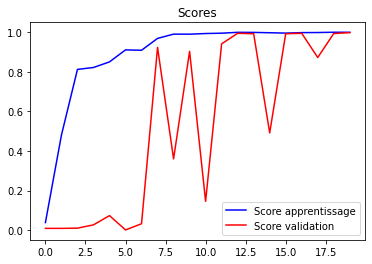

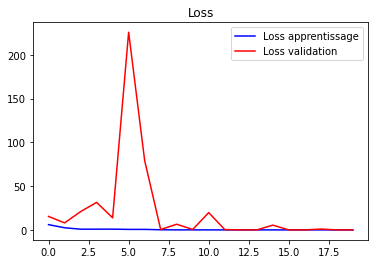

In [13]:
def plot_scores(train):
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()
def plot_loss(train):
    loss = train.history['loss']
    val_loss = train.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'b', label='Loss apprentissage')
    plt.plot(epochs, val_loss, 'r', label='Loss validation')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
plot_scores(trained)
plot_loss(trained)